# Importing all required libraries for the project

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm  

In [2]:
data = pd.read_csv('EEG_data.csv')


In [3]:
data

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,302000.0,90600.0,33700.0,24000.0,27900.0,45100.0,33200.0,8290.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73800.0,28100.0,1440.0,2240.0,2750.0,3690.0,5290.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758000.0,384000.0,202000.0,62100.0,36300.0,131000.0,57200.0,25400.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2010000.0,129000.0,61200.0,17100.0,11500.0,62500.0,50000.0,33900.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1010000.0,354000.0,37100.0,88900.0,45300.0,99600.0,44800.0,29700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,128000.0,9950.0,709.0,21700.0,3870.0,39700.0,2600.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323000.0,797000.0,153000.0,146000.0,39800.0,571000.0,36600.0,10000.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,681000.0,154000.0,40100.0,39100.0,11000.0,27000.0,20400.0,2020.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366000.0,27300.0,11400.0,9930.0,1940.0,3280.0,12300.0,1760.0,1.0,0.0


In [4]:
#Structure data in pandas dataframe with 64 bits floats
df = pd.DataFrame(data, dtype='f8') 

#Assign column labels
df.columns = [
    'Subject', 
    'Video',   
    'Attention', 
    'Meditation', 
    'Raw',
    'Delta', 
    'Theta', 
    'Alpha1', 
    'Alpha2', 
    'Beta1', 
    'Beta2', 
    'Gamma1', 
    'Gamma2', 
    'exp', 
    'obs'
]

#Check for missing values in df
msg_missing = 'Missing values in dataset'
assert(all(df.isnull() == False)), msg_missing

#Assign student number as major index
major = df['Subject'].values 

#Assign video number as minor index
minor = df['Video'].values

#Create MultiIndex from students and videos
df.index = pd.MultiIndex.from_arrays([major, minor])

#Name major and minor index
df.index.levels[0].set_names = 'Subject'
df.index.levels[1].set_names = 'Video'

# #Remove data not part of the analysis
# del df['Subject']
# del df['Video']
# del df['exp']
# del df['Attention']
# del df['Raw']

#Visual check of data
df[:10]

Subject  Video  Attention  Meditation    Raw      Delta     Theta  \
0.0 0.0      0.0    0.0       56.0        43.0  278.0   302000.0   90600.0   
    0.0      0.0    0.0       40.0        35.0  -50.0    73800.0   28100.0   
    0.0      0.0    0.0       47.0        48.0  101.0   758000.0  384000.0   
    0.0      0.0    0.0       47.0        57.0   -5.0  2010000.0  129000.0   
    0.0      0.0    0.0       44.0        53.0   -8.0  1010000.0  354000.0   
    0.0      0.0    0.0       44.0        66.0   73.0  1790000.0  177000.0   
    0.0      0.0    0.0       43.0        69.0  130.0   635000.0  122000.0   
    0.0      0.0    0.0       40.0        61.0   -2.0   161000.0   12100.0   
    0.0      0.0    0.0       43.0        69.0   17.0   493000.0  121000.0   
    0.0      0.0    0.0       47.0        69.0  -59.0    82000.0  116000.0   

           Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  exp  obs  
0.0 0.0   33700.0  24000.0  27900.0   45100.0  33200.0   8290.0  0.0  0.0  
    0.0    1440.0   2240.0   2750.0    3690.0   5290.0   2740.0  0.0  0.0  
    0.0  202000.0  62100.0  36300.0  131000.0  57200.0  25400.0  0.0  0.0  
    0.0   61200.0  17100.0  11500.0   62500.0  50000.0  33900.0  0.0  0.0  
    0.0   37100.0  88900.0  45300.0   99600.0  44800.0  29700.0  0.0  0.0  
    0.0   59400.0  26200.0  15100.0   33700.0  33800.0  31800.0  0.0  0.0  
    0.0   90100.0  65100.0  36200.0   53000.0  62900.0  59300.0  0.0  0.0  
    0.0    1960.0    809.0   1280.0    3190.0   3270.0   2520.0  0.0  0.0  
    0.0   63700.0  68200.0  10800.0   88400.0  73800.0  22700.0  0.0  0.0  
    0.0   47300.0  26200.0  41600.0   28900.0  32600.0  41800.0  0.0  0.0

# Exploratory Data Analysis
Carrying out some Exploratory data analysis on the data to plot the number of videos watched by each subject and vice-versa

In [5]:
df1 = df.groupby(['Subject', 'Video'])['obs'].agg(lambda x: sum(x) > 0).unstack("Video")
df1

Video,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Subject,,,,,,,,,,
0.0,False,True,True,False,False,True,True,False,True,False
1.0,False,True,True,True,True,False,False,False,False,False
2.0,False,True,False,False,True,True,False,True,True,False
3.0,False,False,False,False,True,False,True,True,True,True
4.0,False,True,True,True,False,False,True,True,True,False
5.0,False,True,True,True,False,True,True,False,True,False
6.0,True,False,False,True,True,False,True,False,True,False
7.0,True,True,False,True,True,True,False,True,False,False
8.0,False,False,False,False,True,True,False,False,True,True


### Given the graphical representation of the number of videos confusing to students

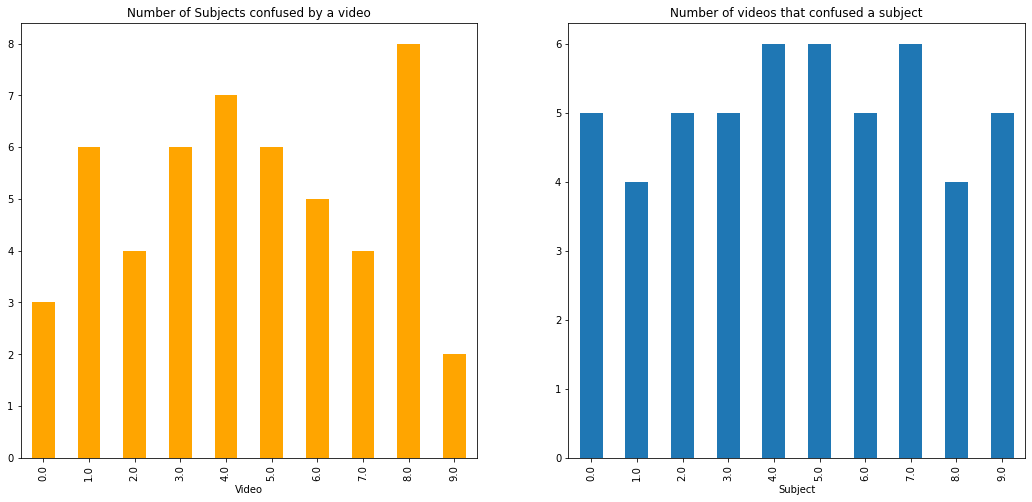

In [6]:
fig = plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
df1.apply(sum).plot(kind='bar', title='Number of Subjects confused by a video', color = 'orange')
plt.subplot(1, 2, 2)
df1.apply(sum, axis=1).plot(kind='bar', title="Number of videos that confused a subject")
plt.show()

## Visualing the attributes of the subject 0 before Normalizing the data

In [7]:
features = ['Attention', 'Meditation', 'Raw', 'Delta',
            'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']

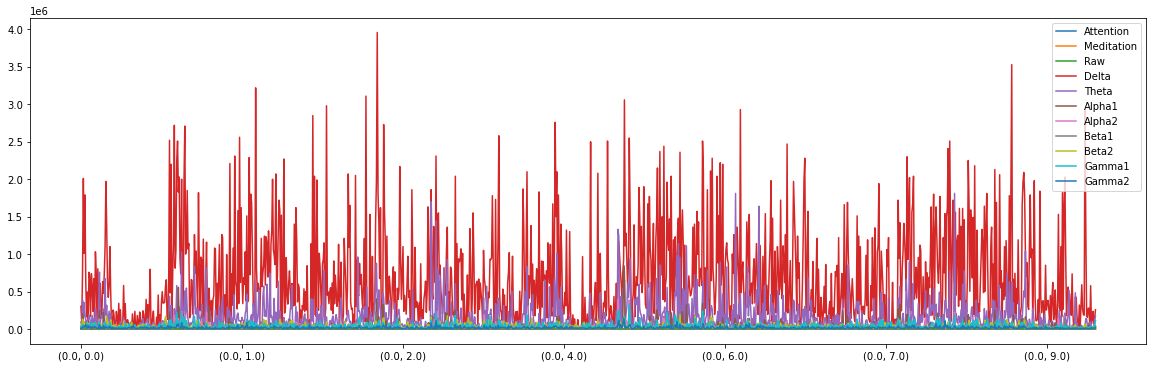

In [8]:
# Extract all values for subjecct o an visualizes them
data_user_video = df.query('Subject==0')
data_user_video[features].plot(figsize=(20,6))
plt.show()

In [9]:
# # # Remove data not part of the analysis
# del df['Subject']
# del df['Video']
# del df['exp']
# #X = df['exp']
#target = df['obs']

# Histograph of features in data set before normalization

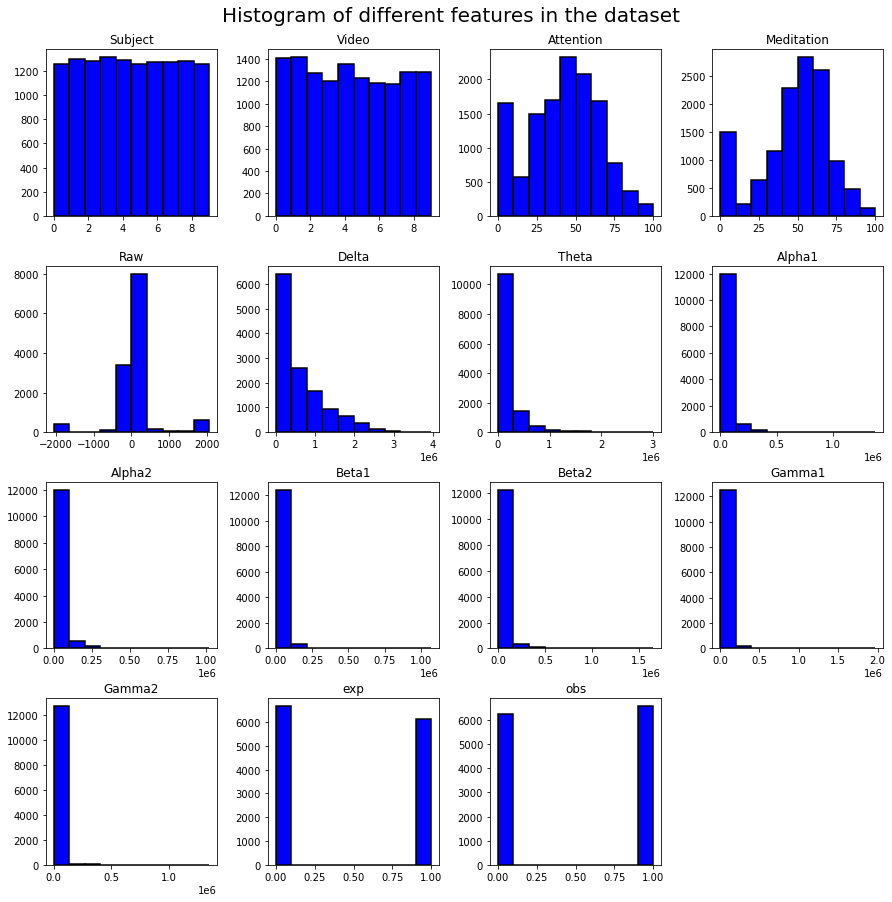

In [9]:
df.hist(figsize = (15, 15), grid = False, color = 'blue', edgecolor = 'black', linewidth = 1.5)
plt.suptitle ('Histogram of different features in the dataset', fontsize = 20, y = 0.92)
plt.show()

In [11]:
df.describe()

,Subject,Video,Attention,Meditation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,exp,obs
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.628288,6.057873e+05,1.680461e+05,4.138325e+04,3.318419e+04,2.431939e+04,3.814329e+04,2.959277e+04,1.441612e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,598.541528,6.376272e+05,2.441232e+05,7.242636e+04,5.831937e+04,3.838424e+04,7.905932e+04,7.983078e+04,3.603291e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2050.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.810000e+04,2.690000e+04,6.840000e+03,6.850000e+03,6.140000e+03,7.360000e+03,4.060000e+03,2.170000e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.950000e+05,8.130000e+04,1.750000e+04,1.500000e+04,1.280000e+04,1.580000e+04,9.760000e+03,5.120000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.170000e+05,2.050000e+05,4.480000e+04,3.455000e+04,2.740000e+04,3.550000e+04,2.490000e+04,1.270000e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2050.000000,3.960000e+06,3.010000e+06,1.370000e+06,1.020000e+06,1.070000e+06,1.650000e+06,1.970000e+06,1.350000e+06,1.000000,1.000000


In [12]:
# Remove data not part of the analysis
del df['Subject']
del df['Video']
del df['exp']



# Normalizing the data to range 0 to 1

In [13]:
target = df.loc[:, 'obs']

X1 = df.loc[:, 'Attention':'Gamma2']

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

scaled_x = NormalizeData(X1)

print(scaled_x)

         Attention  Meditation       Raw     Delta     Theta    Alpha1  \
0.0 0.0       0.56        0.43  0.567805  0.076158  0.030094  0.024597   
    0.0       0.40        0.35  0.487805  0.018525  0.009330  0.001050   
    0.0       0.47        0.48  0.524634  0.191323  0.127570  0.147444   
    0.0       0.47        0.57  0.498780  0.507520  0.042852  0.044670   
    0.0       0.44        0.53  0.498049  0.254966  0.117603  0.027079   
...            ...         ...       ...       ...       ...       ...   
9.0 9.0       0.64        0.38  0.490488  0.032214  0.003300  0.000516   
    9.0       0.61        0.35  0.432927  0.081462  0.264780  0.111678   
    9.0       0.60        0.29  0.396098  0.171876  0.051157  0.029269   
    9.0       0.60        0.29  0.479512  0.092322  0.009064  0.008320   
    9.0       0.64        0.29  0.488049  0.292849  0.392023  0.036495   

           Alpha2     Beta1     Beta2    Gamma1    Gamma2  
0.0 0.0  0.023527  0.026072  0.027332  0.016852  0.

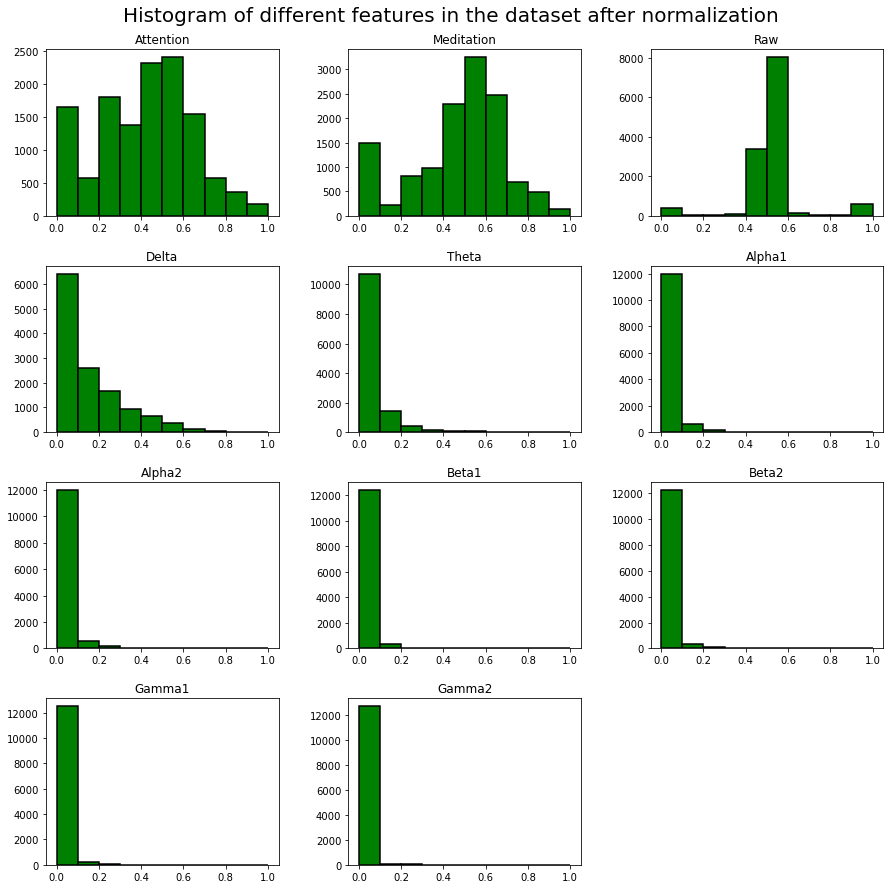

In [14]:
scaled_x.hist(figsize = (15,15), grid = False, color = "green", edgecolor = 'black',linewidth = 1.5 )
plt.suptitle('Histogram of different features in the dataset after normalization',fontsize = 20,y= 0.92)
plt.show()

In [15]:
# # Extract all values for subject 0 an visualizes them
# data_user_video = scaled_x.query('Subject==0')
# data_user_video[features].plot(figsize=(20,6))
# plt.show()

After normalizing the data to 0 and 1, the data did not spread round for each of the variable, to solve this i will rescaled the data
to range between -1 and 1

Comments:
So we managed to spread some of the features in the dataset. Let us now use a combination of tanh normalization and robust scaleing for transforming the data i.e. spreading the data and scaling it in the range [-1,1]


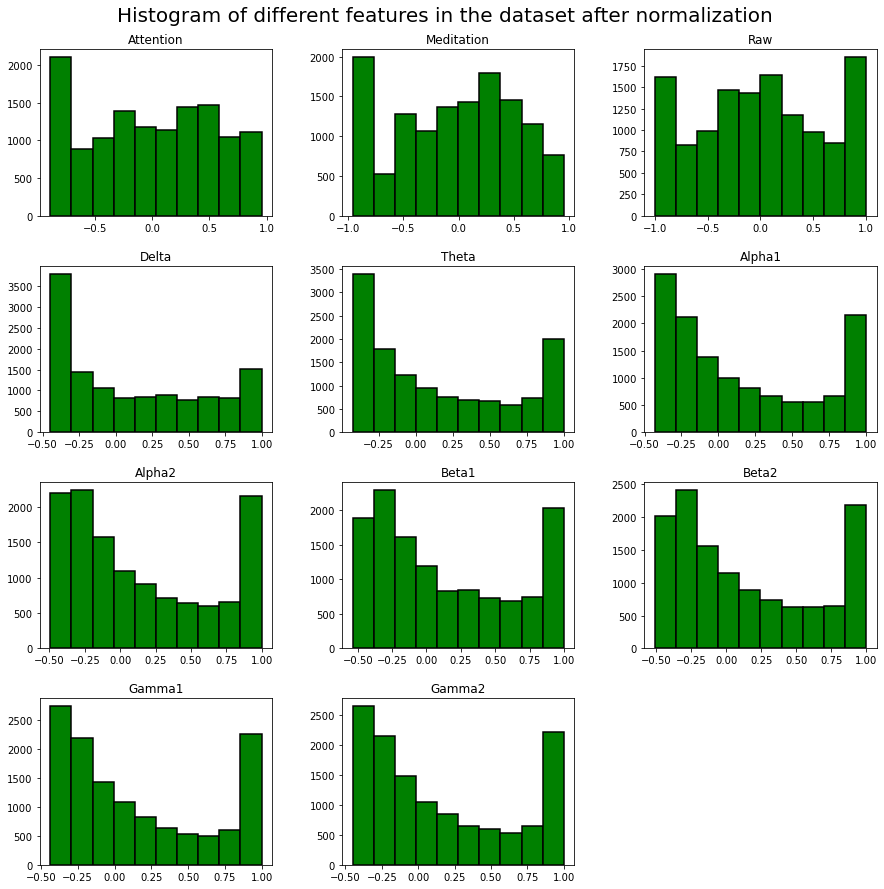

In [16]:

m = np.mean(X1, axis=0) # array([16.25, 26.25])
std = np.std(X1, axis=0) # array([17.45530005, 22.18529919])
md = np.median(X1,axis = 0)
p75 = np.percentile(X1,75,axis = 0)
p25 = np.percentile(X1,25,axis = 0)
X_scaled = np.tanh((X1 - md) / (p75 - p25)) #normalization and feature scaling for train set
X_scaled.hist(figsize = (15,15), grid = False, color = "green", edgecolor = 'black',linewidth = 1.5 )
plt.suptitle('Histogram of different features in the dataset after normalization',fontsize = 20,y= 0.92)
plt.show()

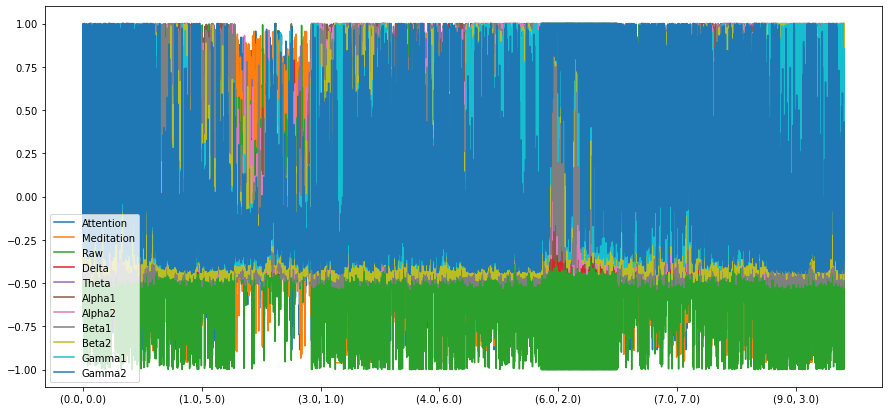

In [17]:
X_scaled.plot(figsize = (15,7))

plt.show()

In [18]:
X_scaled['userdefined'] = target
X_scaled

Attention  Meditation       Raw     Delta     Theta    Alpha1  \
0.0 0.0   0.408103   -0.298336  0.981486 -0.113081  0.052170  0.402614   
    0.0  -0.099668   -0.547906 -0.673602 -0.373284 -0.290130 -0.399519   
    0.0   0.132549   -0.114875  0.561222  0.416358  0.935360  0.999880   
    0.0   0.132549    0.226758 -0.366709  0.962007  0.261602  0.818155   
    0.0   0.033321    0.076772 -0.391408  0.635750  0.910623  0.474865   
...            ...         ...       ...       ...       ...       ...   
9.0 9.0   0.604368   -0.462117 -0.611641 -0.314964 -0.380477 -0.415577   
    9.0   0.537050   -0.547906 -0.994861 -0.087697  0.999354  0.998414   
    9.0   0.512907   -0.689055 -0.999718  0.335709  0.386941  0.533742   
    9.0   0.512907   -0.689055 -0.815834 -0.035399 -0.294239 -0.159326   
    9.0   0.604368   -0.689055 -0.668315  0.732537  0.999991  0.694276   

           Alpha2     Beta1     Beta2    Gamma1    Gamma2  userdefined  
0.0 0.0  0.313940  0.610836  0.778370  0.809218  0.292268          0.0  
    0.0 -0.430614 -0.440393 -0.405612 -0.211261 -0.222249          0.0  
    0.0  0.935454  0.802417  0.999444  0.979144  0.958403          0.0  
    0.0  0.075667 -0.061072  0.930158  0.958806  0.991582          0.0  
    0.0  0.990413  0.910201  0.994833  0.933041  0.981403          0.0  
...           ...       ...       ...       ...       ...          ...  
9.0 9.0  0.237268 -0.396962  0.690717 -0.330661 -0.375716          0.0  
    9.0  0.999844  0.853795  1.000000  0.858578  0.432882          0.0  
    9.0  0.701392 -0.084464  0.378245  0.470379 -0.286177          0.0  
    9.0 -0.181016 -0.470583 -0.417713  0.121281 -0.308682          0.0  
    9.0  0.999236 -0.103113  1.000000  0.531426 -0.060704          0.0  

[12811 rows x 12 columns]

In [19]:
#Grouping data according to student number
grp_vid = X_scaled.groupby(level=0)

#Grouping data according to video number and calculating the mean of observations
sc_ave = grp_vid.apply(lambda x: x.groupby(level=1).mean())

#Visual check of data
sc_ave[:10]

Attention  Meditation       Raw     Delta     Theta    Alpha1  \
0.0 0.0   0.273281    0.082578  0.069107  0.055365  0.080629  0.127070   
    1.0   0.028681   -0.071679 -0.046562  0.257358  0.221849  0.218849   
    2.0   0.031219   -0.106688 -0.138777  0.185170  0.178392  0.112149   
    3.0   0.193366    0.027607  0.013522  0.155284  0.105863  0.118818   
    4.0   0.285465   -0.112198 -0.018719  0.062119  0.045370  0.052132   
    5.0   0.165352   -0.208163  0.018696  0.405931  0.437217  0.375347   
    6.0  -0.261360   -0.213510  0.067654  0.306524  0.307417  0.222481   
    7.0   0.115517   -0.020707 -0.034645  0.048943  0.058980  0.079164   
    8.0   0.305087    0.061760 -0.032316  0.393163  0.305152  0.227275   
    9.0   0.174348   -0.113900 -0.008053  0.104995  0.095534  0.073963   

           Alpha2     Beta1     Beta2    Gamma1    Gamma2  userdefined  
0.0 0.0  0.099299  0.144617  0.459196  0.592627  0.530432          0.0  
    1.0  0.146261  0.235475  0.382225  0.560719  0.438768          1.0  
    2.0  0.095192  0.162368  0.387451  0.513952  0.436849          1.0  
    3.0  0.077628  0.038169  0.452438  0.598363  0.475889          0.0  
    4.0 -0.005646  0.068906  0.424314  0.580929  0.487289          0.0  
    5.0  0.300708  0.252545  0.397501  0.649669  0.540939          1.0  
    6.0  0.160613  0.133619  0.316614  0.465031  0.389150          1.0  
    7.0  0.007378  0.060096  0.429046  0.570549  0.458233          0.0  
    8.0  0.154228  0.153512  0.373439  0.629555  0.493701          1.0  
    9.0  0.043027  0.129886  0.240225  0.399760  0.343796          0.0

In [20]:


X1 = sc_ave.loc[:,'Attention':'Gamma2']

y1 = sc_ave.loc[:, 'userdefined']

# Let's say, components = 2
pca = PCA(n_components = 2).fit(X1)
x_pca = pca.transform(X1)

x_pca.shape

(100, 2)

Text(0, 0.5, 'Second Principal Component')

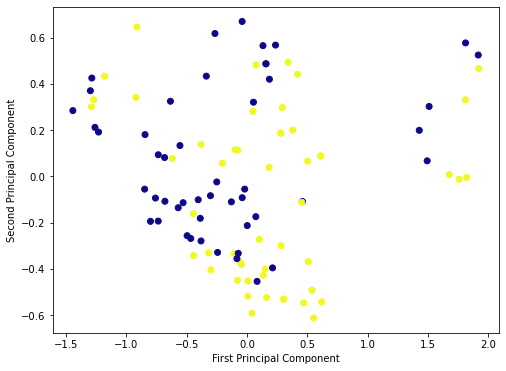

In [21]:
# visualizing the PCA
# giving a larger plot
plt.figure(figsize =(8, 6))
  
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = y1, cmap ='plasma') 
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [22]:
new_X = pd.DataFrame(data = x_pca, columns= ['PC1', 'PC2'])
new_X.head()

,PC1,PC2
0,0.156150,0.486488
1,0.378592,0.200017
2,0.292556,0.297515
3,0.185724,0.420115
4,0.132362,0.565296


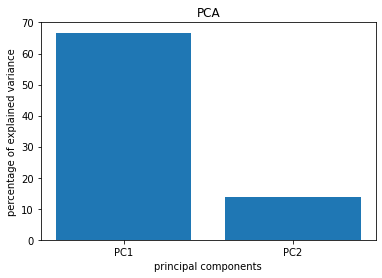

In [23]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)

labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x = range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.xlabel('principal components')
plt.ylabel('percentage of explained variance')
plt.title('PCA')
plt.show()

In [24]:
# components
pca.components_

array([[-0.41851259, -0.42786248,  0.06485942,  0.22890624,  0.23525003,
         0.19463106,  0.23365756,  0.25465874,  0.35132812,  0.36544177,
         0.33989147],
       [ 0.18396649, -0.18789674,  0.04157325, -0.43466732, -0.36661693,
        -0.36202938, -0.28794587, -0.10460874,  0.17443643,  0.29794359,
         0.51152676]])

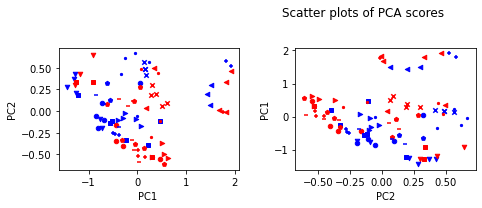

In [25]:
#Extract the value of the PCA that are more than 0.5% and divide it by 1000 to give a clear and more meaningful readings

pc1 = x_pca[:, 0] 
pc2 = x_pca[:, 1] 
#pc3 = x_pca[:, 2] /1000


#Assign markers to separate students
m = [
    "x", # Student no 1
    "o", 
    "v", 
    "s", 
    "p",
    "_",
    "+", #Student no 7
    "<", 
    ".", 
    ">" # Student no 10
]

markers1 = [marker for marker in m for j in range(9)]

#Assign colors to separate confused students from not confused students
colors1 = ['r' if int(student_confused) == 1 else 'blue' for student_confused in y1]

#File name
save_name = 'score1.jpg'

#Plotting
def scorePlots(pc1, pc2, markers, colors, save_name):
    '''
    Creates scatter plots of PCA scores, markers and color labels as three 
    subplots in one figure of size [10, 3]. Axis labels are respective PC's.
    
    Args:
        pc1 (ndarray) : 1D array of PC1 scores
        pc2 (ndarray) : 1D array of PC2 scores
        pc3 (ndarray) : 1D array of PC3 scores
        markers (list) : list of markers for (1) each scores, (2) confused/not confused
        colors (list) : list of colors for (1) each scores, (2) confused/not confused
        save_name (str) : name of pictured saved to disk
    
    Returns:
        None
    '''    
    
    fig = plt.figure(figsize=[10, 3])
    fig.suptitle('Scatter plots of PCA scores')

    ax1 = fig.add_subplot(131)
    ax1.patch.set_facecolor('white')
    for _pc1, _pc2, _marker, _color in zip(pc1, pc2, markers, colors):
        ax1.scatter(_pc1, _pc2, marker=_marker, color=_color, s=20)
    plt.xlabel('PC1 ')
    plt.ylabel('PC2')

    ax2 = fig.add_subplot(132)
    ax2.patch.set_facecolor('white')
    for _pc2, _pc3, _marker, _color in zip(pc2, pc1, markers, colors):
        ax2.scatter(_pc2, _pc3, marker=_marker, color=_color, s=20)
    plt.xlabel('PC2')
    plt.ylabel('PC1')

    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_name)

#Call plotting function
scorePlots(pc1, pc2, markers1, colors1, save_name)

In [26]:
# All necessary libraries have been included in the first box
# Importing standardscalar module
# from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

# fitting
scalar.fit(X1)
scaled_data = scalar.transform(X1)

In [27]:
# Let's say, components = 2
sc_pca = PCA(n_components = 2).fit(scaled_data)
scx_pca = pca.transform(scaled_data)

scx_pca.shape

(100, 2)

In [28]:
sc_pca.explained_variance_ratio_

array([0.65010136, 0.16149502])

Text(0, 0.5, 'Second Principal Component')

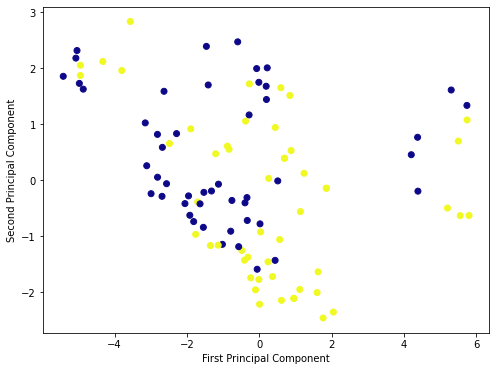

In [29]:
# visualizing the PCA
# giving a larger plot
plt.figure(figsize =(8, 6))
  
plt.scatter(scx_pca[:, 0], scx_pca[:, 1], c = y1, cmap ='plasma') 
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# introducting the non-linear dimension Reduction called Kernel

In [31]:
from sklearn.decomposition import KernelPCA

In [32]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X1)
X_back = kpca.inverse_transform(X_kpca)

In [33]:
X_back 

array([[ 0.13673016,  0.04130002,  0.03455882, ...,  0.22980691,
         0.29658971,  0.26543599],
       [ 0.0143539 , -0.03588508, -0.02334011, ...,  0.19127723,
         0.28057835,  0.21957002],
       [ 0.01562283, -0.05337572, -0.06940846, ...,  0.19389136,
         0.25721892,  0.21861581],
       ...,
       [-0.21534847, -0.0331193 , -0.02298914, ...,  0.01132212,
         0.05140936, -0.12634348],
       [ 0.20339154,  0.04117323, -0.02154382, ...,  0.24895964,
         0.41970343,  0.32913407],
       [ 0.03595239, -0.07374774, -0.02605761, ...,  0.19288036,
         0.10299877, -0.10235577]])

In [34]:
X_kpca

array([[ 4.51443032e-01,  1.16271295e-01, -1.39104800e-01, ...,
         1.16408913e-04,  8.21555647e-05, -2.60851222e-05],
       [ 3.93969875e-01,  8.16313070e-02, -1.10150867e-01, ...,
        -6.75979225e-05, -2.41521266e-05,  5.58185692e-06],
       [ 5.18990185e-01,  1.18188330e-01, -1.72591871e-01, ...,
         1.70230888e-04,  8.46248247e-05, -2.36436425e-05],
       ...,
       [-4.98577029e-03, -1.30264670e-02,  4.69672152e-02, ...,
         2.86108586e-04,  1.31475470e-04, -4.54158080e-05],
       [ 2.19940447e-01,  4.53082261e-02, -2.13099460e-02, ...,
         7.15370448e-05,  5.75822669e-05, -1.95494747e-05],
       [-1.65998301e-02, -5.00836124e-02,  4.73976827e-02, ...,
         4.17572742e-03,  7.45332683e-05, -2.97402981e-05]])

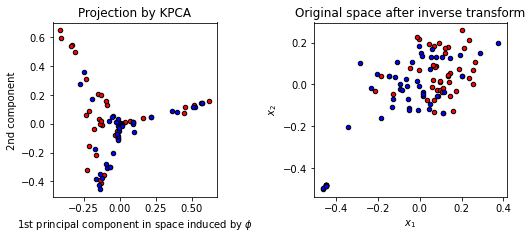

In [35]:
plt.figure(figsize =(8, 6))

reds = y1 == 0
blues = y1 == 1


plt.subplot(2, 2, 3, aspect="equal")
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20, edgecolor="k")
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect="equal")
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue", s=20, edgecolor="k")
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

### The above data confirmed that the dataset is both linearly and non-linearly inseparable based on PCA and Kernel PCA method of separations

# Using T-SNE Distribution

In [36]:
from sklearn.manifold import TSNE
from __future__ import print_function
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.535127
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.668823
[t-SNE] KL divergence after 300 iterations: 0.536224
t-SNE done! Time elapsed: 0.3950495719909668 seconds


C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

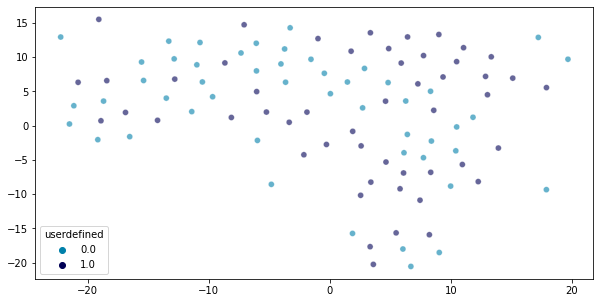

In [37]:
X1['tsne-2d-one'] = tsne_results[:,0]
X1['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(
    tsne_results[:,0], tsne_results[:,1],
    hue=y1,
    palette=sns.color_palette("ocean_r", 2),
    data=X1,
    legend="full",
    alpha=0.6
)

# plt.scatter(tsne_results[:,0], tsne_results[:,1], c = y1, cmap ='plasma') 
# # labeling x and y axes
# plt.xlabel('First tsne')
# plt.ylabel('Second tsne')

#sns.countplot(x="Hospital Type", data=data, hue="Emergency Services", palette="ocean_r")

In [38]:
time_start = time.time()
tsne1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results1 = tsne.fit_transform(scaled_data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.885638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.118385
[t-SNE] KL divergence after 300 iterations: 0.454324
t-SNE done! Time elapsed: 0.30114102363586426 seconds


C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

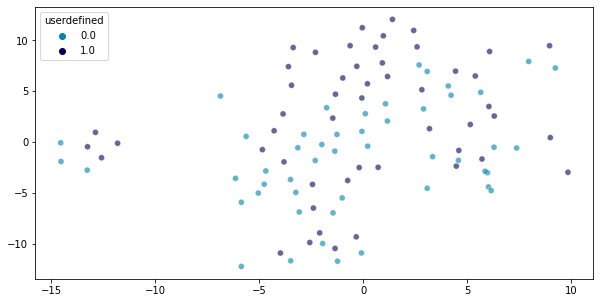

In [39]:
# scaled_data['tsne-2d-one'] = tsne_results1[:,0]
# scaled_data['tsne-2d-two'] = tsne_results1[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(
    tsne_results1[:,0], tsne_results1[:,1],
    hue=y1,
    palette=sns.color_palette("ocean_r", 2),
    data=X1,
    legend="full",
    alpha=0.6
)


Using T-SNE i discovered that the data is also non-linearly separable

In [40]:
del X1['tsne-2d-one']
del X1['tsne-2d-two']

# Autoencoder Dimension Reduction

In [41]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.optimizers import SGD

Epoch 1/400
5/5 - 5s - loss: 0.5635 - val_loss: 0.2161
Epoch 2/400
5/5 - 0s - loss: 0.4717 - val_loss: 0.2112
Epoch 3/400
5/5 - 0s - loss: 0.4257 - val_loss: 0.2060
Epoch 4/400
5/5 - 0s - loss: 0.3527 - val_loss: 0.2008
Epoch 5/400
5/5 - 0s - loss: 0.2925 - val_loss: 0.1946
Epoch 6/400
5/5 - 0s - loss: 0.2752 - val_loss: 0.1874
Epoch 7/400
5/5 - 0s - loss: 0.2377 - val_loss: 0.1794
Epoch 8/400
5/5 - 0s - loss: 0.2178 - val_loss: 0.1711
Epoch 9/400
5/5 - 0s - loss: 0.2006 - val_loss: 0.1638
Epoch 10/400
5/5 - 0s - loss: 0.1767 - val_loss: 0.1573
Epoch 11/400
5/5 - 0s - loss: 0.1543 - val_loss: 0.1510
Epoch 12/400
5/5 - 0s - loss: 0.1377 - val_loss: 0.1452
Epoch 13/400
5/5 - 0s - loss: 0.1295 - val_loss: 0.1396
Epoch 14/400
5/5 - 0s - loss: 0.1264 - val_loss: 0.1338
Epoch 15/400
5/5 - 0s - loss: 0.1132 - val_loss: 0.1299
Epoch 16/400
5/5 - 0s - loss: 0.1018 - val_loss: 0.1248
Epoch 17/400
5/5 - 0s - loss: 0.0941 - val_loss: 0.1197
Epoch 18/400
5/5 - 0s - loss: 0.1056 - val_loss: 0.1154
E

Epoch 147/400
5/5 - 0s - loss: 0.0125 - val_loss: 0.0120
Epoch 148/400
5/5 - 0s - loss: 0.0115 - val_loss: 0.0120
Epoch 149/400
5/5 - 0s - loss: 0.0168 - val_loss: 0.0120
Epoch 150/400
5/5 - 0s - loss: 0.0145 - val_loss: 0.0118
Epoch 151/400
5/5 - 0s - loss: 0.0174 - val_loss: 0.0116
Epoch 152/400
5/5 - 0s - loss: 0.0248 - val_loss: 0.0115
Epoch 153/400
5/5 - 0s - loss: 0.0128 - val_loss: 0.0116
Epoch 154/400
5/5 - 0s - loss: 0.0154 - val_loss: 0.0119
Epoch 155/400
5/5 - 0s - loss: 0.0109 - val_loss: 0.0121
Epoch 156/400
5/5 - 0s - loss: 0.0152 - val_loss: 0.0122
Epoch 157/400
5/5 - 0s - loss: 0.0201 - val_loss: 0.0121
Epoch 158/400
5/5 - 0s - loss: 0.0166 - val_loss: 0.0119
Epoch 159/400
5/5 - 0s - loss: 0.0218 - val_loss: 0.0119
Epoch 160/400
5/5 - 0s - loss: 0.0150 - val_loss: 0.0115
Epoch 161/400
5/5 - 0s - loss: 0.0134 - val_loss: 0.0112
Epoch 162/400
5/5 - 0s - loss: 0.0162 - val_loss: 0.0112
Epoch 163/400
5/5 - 0s - loss: 0.0231 - val_loss: 0.0113
Epoch 164/400
5/5 - 0s - loss: 

Epoch 291/400
5/5 - 0s - loss: 0.0144 - val_loss: 0.0074
Epoch 292/400
5/5 - 0s - loss: 0.0191 - val_loss: 0.0072
Epoch 293/400
5/5 - 0s - loss: 0.0115 - val_loss: 0.0071
Epoch 294/400
5/5 - 0s - loss: 0.0080 - val_loss: 0.0072
Epoch 295/400
5/5 - 0s - loss: 0.0140 - val_loss: 0.0072
Epoch 296/400
5/5 - 0s - loss: 0.0125 - val_loss: 0.0072
Epoch 297/400
5/5 - 0s - loss: 0.0095 - val_loss: 0.0069
Epoch 298/400
5/5 - 0s - loss: 0.0114 - val_loss: 0.0068
Epoch 299/400
5/5 - 0s - loss: 0.0104 - val_loss: 0.0069
Epoch 300/400
5/5 - 0s - loss: 0.0167 - val_loss: 0.0070
Epoch 301/400
5/5 - 0s - loss: 0.0097 - val_loss: 0.0070
Epoch 302/400
5/5 - 0s - loss: 0.0075 - val_loss: 0.0070
Epoch 303/400
5/5 - 0s - loss: 0.0112 - val_loss: 0.0070
Epoch 304/400
5/5 - 0s - loss: 0.0121 - val_loss: 0.0069
Epoch 305/400
5/5 - 0s - loss: 0.0137 - val_loss: 0.0068
Epoch 306/400
5/5 - 0s - loss: 0.0127 - val_loss: 0.0068
Epoch 307/400
5/5 - 0s - loss: 0.0092 - val_loss: 0.0068
Epoch 308/400
5/5 - 0s - loss: 

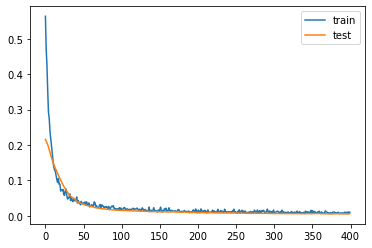

In [42]:

# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# number of input columns
n_inputs = X1.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

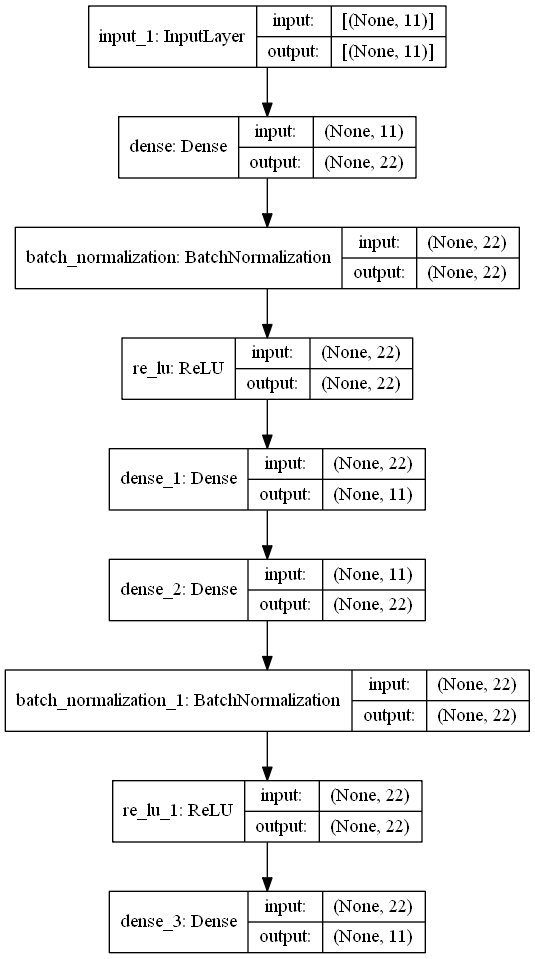

In [40]:
plot_model(model, 'autoencoder.png', show_shapes=True)

Epoch 1/400
561/561 - 2s - loss: 0.0866 - val_loss: 0.0069
Epoch 2/400
561/561 - 1s - loss: 0.0081 - val_loss: 0.0043
Epoch 3/400
561/561 - 1s - loss: 0.0057 - val_loss: 0.0031
Epoch 4/400
561/561 - 1s - loss: 0.0047 - val_loss: 0.0024
Epoch 5/400
561/561 - 1s - loss: 0.0042 - val_loss: 0.0021
Epoch 6/400
561/561 - 1s - loss: 0.0036 - val_loss: 0.0017
Epoch 7/400
561/561 - 1s - loss: 0.0033 - val_loss: 0.0015
Epoch 8/400
561/561 - 1s - loss: 0.0031 - val_loss: 0.0013
Epoch 9/400
561/561 - 1s - loss: 0.0028 - val_loss: 0.0011
Epoch 10/400
561/561 - 1s - loss: 0.0028 - val_loss: 0.0012
Epoch 11/400
561/561 - 1s - loss: 0.0026 - val_loss: 9.3701e-04
Epoch 12/400
561/561 - 1s - loss: 0.0025 - val_loss: 9.2053e-04
Epoch 13/400
561/561 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 14/400
561/561 - 1s - loss: 0.0024 - val_loss: 7.9256e-04
Epoch 15/400
561/561 - 1s - loss: 0.0023 - val_loss: 9.0830e-04
Epoch 16/400
561/561 - 1s - loss: 0.0023 - val_loss: 9.5325e-04
Epoch 17/400
561/561 - 1s - l

Epoch 130/400
561/561 - 1s - loss: 0.0012 - val_loss: 6.2414e-04
Epoch 131/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.1612e-04
Epoch 132/400
561/561 - 1s - loss: 0.0011 - val_loss: 3.1842e-04
Epoch 133/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.2085e-04
Epoch 134/400
561/561 - 1s - loss: 0.0012 - val_loss: 4.5534e-04
Epoch 135/400
561/561 - 1s - loss: 0.0011 - val_loss: 5.6198e-04
Epoch 136/400
561/561 - 1s - loss: 0.0011 - val_loss: 6.8990e-04
Epoch 137/400
561/561 - 1s - loss: 0.0011 - val_loss: 3.1728e-04
Epoch 138/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.6517e-04
Epoch 139/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.3952e-04
Epoch 140/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.5579e-04
Epoch 141/400
561/561 - 1s - loss: 0.0011 - val_loss: 6.2713e-04
Epoch 142/400
561/561 - 1s - loss: 0.0011 - val_loss: 3.7658e-04
Epoch 143/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.2809e-04
Epoch 144/400
561/561 - 1s - loss: 0.0011 - val_loss: 4.4054e-04
Epoch 145/400
561/561 - 1

Epoch 255/400
561/561 - 1s - loss: 0.0010 - val_loss: 4.7002e-04
Epoch 256/400
561/561 - 1s - loss: 9.7237e-04 - val_loss: 4.2752e-04
Epoch 257/400
561/561 - 1s - loss: 9.4196e-04 - val_loss: 4.2740e-04
Epoch 258/400
561/561 - 1s - loss: 9.6730e-04 - val_loss: 4.3403e-04
Epoch 259/400
561/561 - 1s - loss: 9.7740e-04 - val_loss: 3.5108e-04
Epoch 260/400
561/561 - 1s - loss: 0.0010 - val_loss: 3.2401e-04
Epoch 261/400
561/561 - 1s - loss: 9.6076e-04 - val_loss: 3.0393e-04
Epoch 262/400
561/561 - 1s - loss: 9.8672e-04 - val_loss: 4.2029e-04
Epoch 263/400
561/561 - 1s - loss: 9.7078e-04 - val_loss: 5.8894e-04
Epoch 264/400
561/561 - 1s - loss: 0.0010 - val_loss: 4.1716e-04
Epoch 265/400
561/561 - 1s - loss: 9.6715e-04 - val_loss: 3.9995e-04
Epoch 266/400
561/561 - 1s - loss: 9.8678e-04 - val_loss: 2.9539e-04
Epoch 267/400
561/561 - 1s - loss: 9.9641e-04 - val_loss: 6.0210e-04
Epoch 268/400
561/561 - 1s - loss: 9.8468e-04 - val_loss: 4.0359e-04
Epoch 269/400
561/561 - 1s - loss: 0.0010 - va

Epoch 375/400
561/561 - 1s - loss: 9.5421e-04 - val_loss: 9.1559e-04
Epoch 376/400
561/561 - 1s - loss: 9.2470e-04 - val_loss: 4.3682e-04
Epoch 377/400
561/561 - 1s - loss: 9.3719e-04 - val_loss: 3.7409e-04
Epoch 378/400
561/561 - 1s - loss: 9.8567e-04 - val_loss: 3.9209e-04
Epoch 379/400
561/561 - 1s - loss: 9.7078e-04 - val_loss: 3.1063e-04
Epoch 380/400
561/561 - 1s - loss: 9.3580e-04 - val_loss: 3.3454e-04
Epoch 381/400
561/561 - 1s - loss: 9.4511e-04 - val_loss: 3.8723e-04
Epoch 382/400
561/561 - 1s - loss: 9.7670e-04 - val_loss: 3.2593e-04
Epoch 383/400
561/561 - 1s - loss: 9.7260e-04 - val_loss: 4.3838e-04
Epoch 384/400
561/561 - 1s - loss: 9.1657e-04 - val_loss: 5.0685e-04
Epoch 385/400
561/561 - 1s - loss: 9.3361e-04 - val_loss: 3.4256e-04
Epoch 386/400
561/561 - 1s - loss: 9.7078e-04 - val_loss: 4.4811e-04
Epoch 387/400
561/561 - 1s - loss: 9.1645e-04 - val_loss: 2.6001e-04
Epoch 388/400
561/561 - 1s - loss: 9.3478e-04 - val_loss: 4.5310e-04
Epoch 389/400
561/561 - 1s - loss:

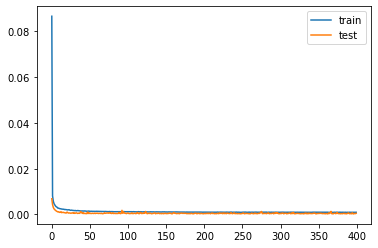

NameError: name 'Model1' is not defined

In [44]:
# Using the all data set to carry out dimensional reduction on the main data set

# define dataset
target = df.loc[:, 'obs']

X2 = df.loc[:, 'Attention':'Gamma2']

# number of input columns
n_inputs = X2.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X2, target, test_size=0.30, random_state=1)
# scale data
t1 = MinMaxScaler()
t1.fit(X_train)
X_train = t1.transform(X_train)
X_test = t1.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model1 = Model(inputs=visible, outputs=output)
# compile autoencoder model
model1.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model1, 'autoencoder.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history1 = model1.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder1 = model1(inputs=visible, outputs=bottleneck)
plot_model(encoder1, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [81]:
# # define an encoder model (without the decoder)
# encoder1 = Model(inputs=visible, outputs=bottleneck)
# plot_model(encoder1, 'encoder.png', show_shapes=True)
# # save the encoder to file
# encoder.save('encoder.h5')

In [45]:
 y1.value_counts()

1.0    51
0.0    49
Name: userdefined, dtype: int64

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


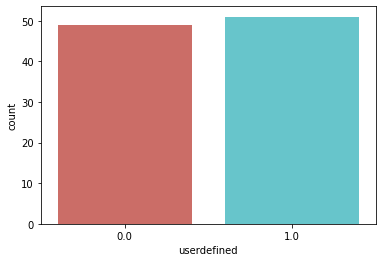

<Figure size 432x288 with 0 Axes>

In [46]:
#this show that the target values is balanced
sns.countplot(y1, data = sc_ave, palette = 'hls')
plt.show()
plt.savefig('target count plot')

In [11]:
#On the origninal data

label = df.loc[:, 'obs']

X2 = df.loc[:, 'Attention':'Gamma2']

# FEATURE SELECTION

In [12]:
from sklearn.ensemble import ExtraTreesClassifier

fe_model = ExtraTreesClassifier()
fe_model.fit(X2, label)
print(fe_model.feature_importances_)

[0.09547761 0.07977883 0.08420813 0.09997091 0.09493502 0.08709659
 0.08817826 0.08971906 0.09030956 0.09359631 0.09672971]


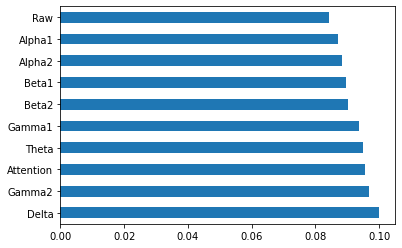

In [13]:
feat_importances = pd.Series(fe_model.feature_importances_, index = X2.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

# Building Machine Learning Model

#### To Begin with the dataset will be splitted to 70 for training and 30 for testing on the mean variable. Standardize the variable to range 0 to 1.

In [45]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=20)
# scaling the data
Sca_t = MinMaxScaler()
Sca_t.fit(X_train)
X_train = Sca_t.transform(X_train)
X_test = Sca_t.transform(X_test)

# 1. Logistic Regression

In [46]:
lg_clf1 = LogisticRegression(solver='lbfgs', max_iter=2000)
lg_clf1.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [47]:
lg_pred = lg_clf1.predict(X_test)
lg_pred

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.])

In [48]:
#to check the score
lg_clf1.score(X_test, y_test)

0.6

In [49]:
lg_clf1.predict_proba(X_test)

array([[0.56431057, 0.43568943],
       [0.59660776, 0.40339224],
       [0.52815651, 0.47184349],
       [0.61359424, 0.38640576],
       [0.28454802, 0.71545198],
       [0.55040466, 0.44959534],
       [0.46167417, 0.53832583],
       [0.35132246, 0.64867754],
       [0.5728264 , 0.4271736 ],
       [0.64815322, 0.35184678],
       [0.6014238 , 0.3985762 ],
       [0.45163375, 0.54836625],
       [0.31144938, 0.68855062],
       [0.47952879, 0.52047121],
       [0.39043   , 0.60957   ],
       [0.53933229, 0.46066771],
       [0.78364185, 0.21635815],
       [0.23394507, 0.76605493],
       [0.46483013, 0.53516987],
       [0.4101334 , 0.5898666 ],
       [0.41634821, 0.58365179],
       [0.44771075, 0.55228925],
       [0.43539169, 0.56460831],
       [0.38892259, 0.61107741],
       [0.53967718, 0.46032282],
       [0.80421593, 0.19578407],
       [0.469885  , 0.530115  ],
       [0.40123271, 0.59876729],
       [0.32050225, 0.67949775],
       [0.54034754, 0.45965246]])

In [50]:
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, lg_pred))



              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54        13
         1.0       0.65      0.65      0.65        17

    accuracy                           0.60        30
   macro avg       0.59      0.59      0.59        30
weighted avg       0.60      0.60      0.60        30



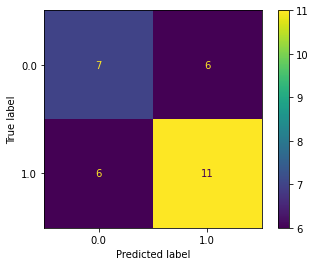

In [51]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lg_pred, labels = lg_clf1.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lg_clf1.classes_)
disp1.plot()

plt.show()

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


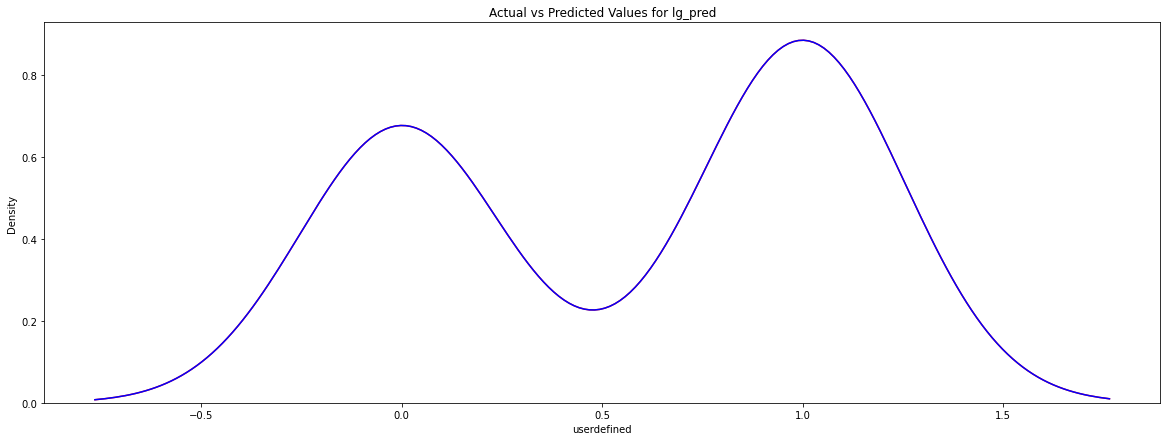

In [52]:
plt.figure(figsize=(20, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( lg_pred, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for lg_pred')


plt.show()
plt.close()

In [54]:
#On the origninal data

label = df.loc[:, 'obs']

X2 = df.loc[:, 'Attention':'Gamma2']

# Splitting and Standardizing the Origninal Data

In [55]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X2, label, test_size=0.30, random_state=20)
# scaling the data
Sca = MinMaxScaler()
Sca.fit(X_train)
X_train = Sca.transform(X_train)
X_test = Sca.transform(X_test)

In [56]:
lg = LogisticRegression(solver='lbfgs', max_iter=2000)
lg.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [57]:
lg_pred1 = lg.predict(X_test)
lg_pred1

array([1., 1., 0., ..., 1., 1., 0.])

In [58]:
lg.score(X_test, y_test)

0.5907908428720083

In [59]:
lg.predict_proba(X_test)

array([[0.48914478, 0.51085522],
       [0.45627878, 0.54372122],
       [0.63135376, 0.36864624],
       ...,
       [0.49273632, 0.50726368],
       [0.48745449, 0.51254551],
       [0.52800196, 0.47199804]])

In [60]:
from sklearn.metrics import classification_report 

print(classification_report(y_test, lg_pred1))

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59      1882
         1.0       0.60      0.59      0.59      1962

    accuracy                           0.59      3844
   macro avg       0.59      0.59      0.59      3844
weighted avg       0.59      0.59      0.59      3844



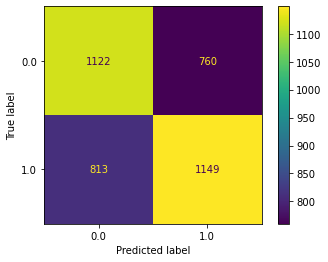

In [61]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lg_pred1, labels = lg.classes_)
show = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lg.classes_)
show.plot()

plt.show()

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


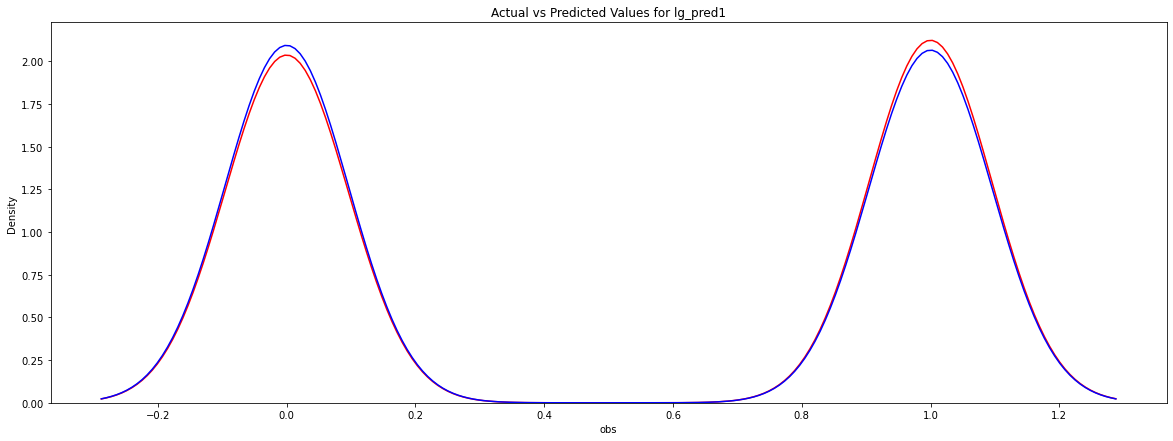

In [62]:
plt.figure(figsize=(20, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( lg_pred1, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for lg_pred1')


plt.show()
plt.close()

# Plotting the ROC Curve

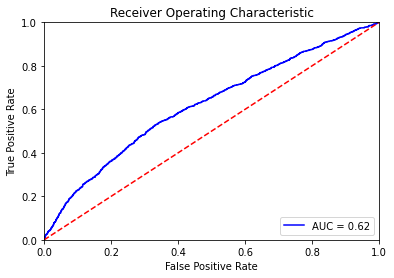

In [63]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lg.predict_proba(X_test)
lg_pred = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, lg_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# 2. Random Forest 

In [64]:
#shuffle data
np.random.seed(42)

Rf_clf = RandomForestClassifier()

Rf_fit = Rf_clf.fit(X_train, y_train)

y_preds1 = Rf_clf.predict(X_test)

Rf_clf.score(X_test, y_test)

# base_metrics = evaluate_preds(y_test, y_preds1)
# base_metrics

0.6586888657648283

In [65]:
from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy_rf = accuracy_score(y_test, y_preds1)
print("Accuracy: %.2f%%" % (accuracy_rf * 100.0))

Accuracy: 65.87%


In [66]:
# for the classification report
print(classification_report(y_test, y_preds1))



              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65      1882
         1.0       0.67      0.67      0.67      1962

    accuracy                           0.66      3844
   macro avg       0.66      0.66      0.66      3844
weighted avg       0.66      0.66      0.66      3844



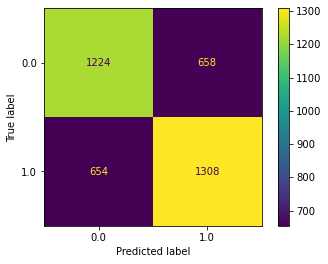

In [67]:
# confusion matrix on random forest
cm_rf1 = confusion_matrix(y_test, y_preds1, labels = Rf_clf.classes_)
show1 = ConfusionMatrixDisplay(confusion_matrix=cm_rf1,
                               display_labels=Rf_clf.classes_)
show1.plot()

plt.show()

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


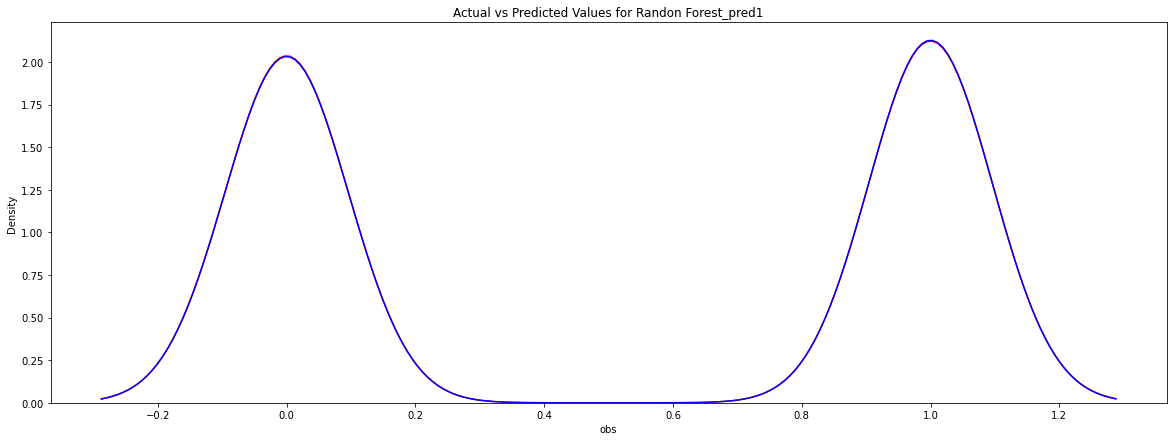

In [74]:
plt.figure(figsize=(20, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( y_preds1, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for Randon Forest_pred1')


plt.show()
plt.close()

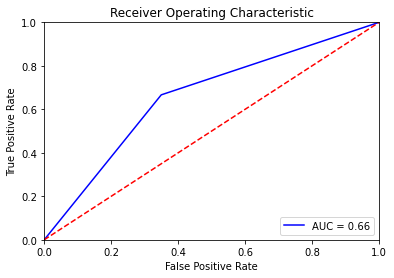

In [75]:
# calculate the fpr and tpr for all thresholds of the classification
probs_rf = Rf_clf.predict_proba(X_test)
rf_pred = probs[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, y_preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# RF with RandomizedSearchCV

In [76]:
from sklearn.model_selection import RandomizedSearchCV

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
        'max_depth' : [None, 5, 10,20,30],
        'max_features'  : ['auto', 'sqrt'],
        'min_samples_split' : [2, 4, 6],
        'min_samples_leaf' : [1, 2, 4]}

Rf_clf2 = RandomForestClassifier(n_jobs = 1)

rs_clf = RandomizedSearchCV(estimator = Rf_clf2,
                            param_distributions = grid,
                            n_iter = 10, # number of models to try
                            cv = 5,
                            verbose = 2) 
#fit the randomizedsearchcv version of clf
rs_clf.fit(X_train, y_train);  

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   5.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   5.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   5.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   5.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   5.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; t

In [77]:
rs_clf.best_params_

{'n_estimators': 1200,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

In [78]:
# make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

#Evaluates the predictions
rs_clf.score(X_test, y_test)

0.6618106139438086

In [79]:
print(classification_report(y_test, rs_y_preds))

              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65      1882
         1.0       0.67      0.68      0.67      1962

    accuracy                           0.66      3844
   macro avg       0.66      0.66      0.66      3844
weighted avg       0.66      0.66      0.66      3844



In [80]:
# evaluate predictions
accuracy_rsf1 = accuracy_score(y_test, rs_y_preds)
print("Accuracy: %.2f%%" % (accuracy_rsf1 * 100.0))

Accuracy: 66.18%


C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


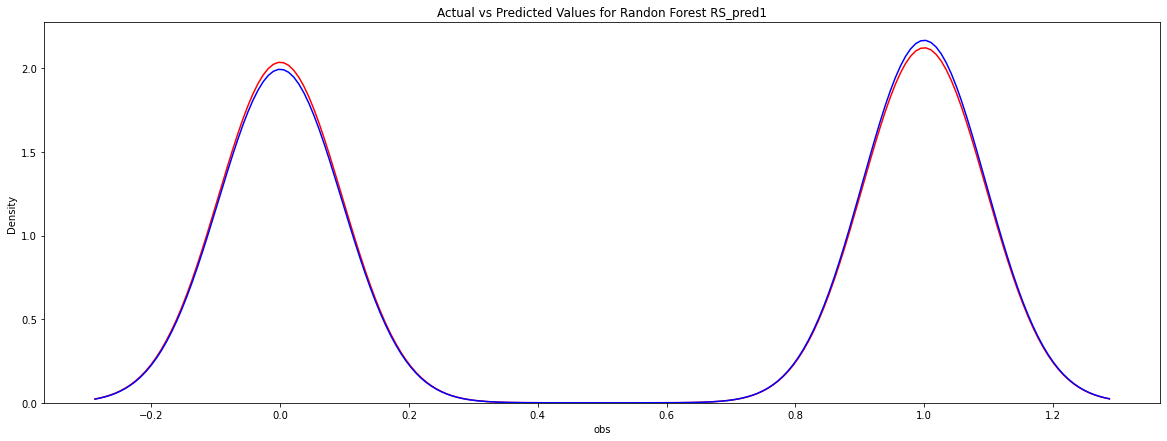

In [81]:
plt.figure(figsize=(20, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( rs_y_preds, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for Randon Forest RS_pred1')


plt.show()
plt.close()

# RF With GridSearchCV Hyperparameter 

In [82]:
from sklearn.model_selection import GridSearchCV

grid_2 = {'n_estimators' : [100, 200, 500],
          'max_depth' : [None],
          'max_features'  : ['auto', 'sqrt'],
          'min_samples_split' : [6],
          'min_samples_leaf' : [1, 2]}

#instantiate RandomForestClassifier
Rf_clf3 = RandomForestClassifier(n_jobs = 2)

# setup GridSearchCV
gs_clf = GridSearchCV(estimator = Rf_clf3,
                            param_grid = grid_2,
                            cv = 5,
                            verbose = 2) 
#fit the Gridsearchcv version of clf
gs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   4.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   2.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   2.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, 

In [83]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 500}

In [84]:
# make predictions with the best hyperparameters
gs_y_preds = gs_clf.predict(X_test)

#Evaluates the predictions
gs_clf.score(X_test, y_test)

0.663111342351717

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


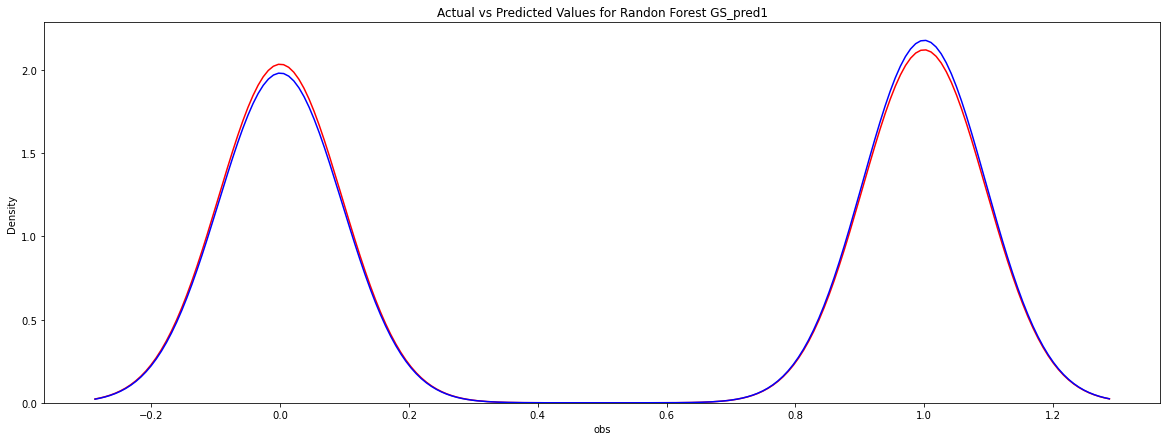

In [87]:
plt.figure(figsize=(20, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( gs_y_preds, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for Randon Forest GS_pred1')


plt.show()
plt.close()

In [86]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy_gsf1 = accuracy_score(y_test, gs_y_preds)
print("Accuracy: %.2f%%" % (accuracy_gsf1 * 100.0))

print(classification_report(y_test, gs_y_preds))

Accuracy: 66.31%
              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65      1882
         1.0       0.67      0.68      0.67      1962

    accuracy                           0.66      3844
   macro avg       0.66      0.66      0.66      3844
weighted avg       0.66      0.66      0.66      3844



# Support Vector Machine

In [89]:
#shuffle data
np.random.seed(42)

svc = svm.SVC(kernel='rbf')

svc_fit = svc.fit(X_train, y_train)

svc_preds = svc.predict(X_test)

svc.score(X_test, y_test)

0.6118626430801248

In [90]:
# evaluate predictions

accuracy_svc1 = accuracy_score(y_test, svc_preds)

print("Accuracy: %.2f%%" % (accuracy_svc1 * 100.0))

print(classification_report(y_test, svc_preds))


Accuracy: 61.19%
              precision    recall  f1-score   support

         0.0       0.60      0.63      0.61      1882
         1.0       0.63      0.60      0.61      1962

    accuracy                           0.61      3844
   macro avg       0.61      0.61      0.61      3844
weighted avg       0.61      0.61      0.61      3844



C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


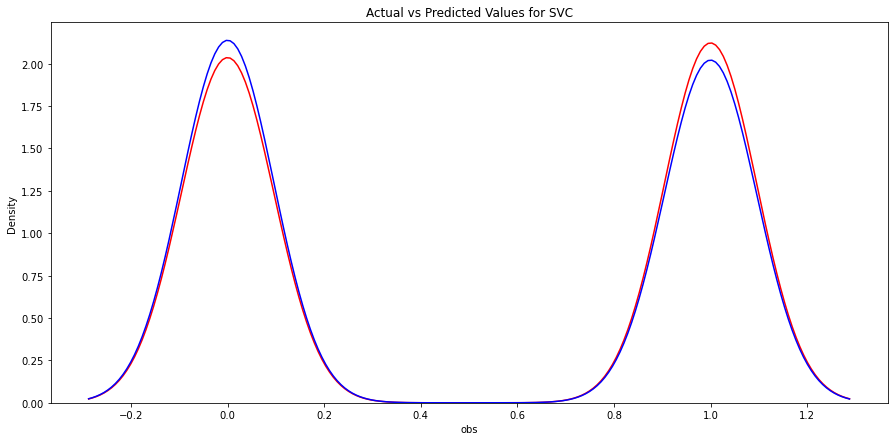

In [118]:
plt.figure(figsize=(15, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( svc_preds, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for SVC')


plt.show()
plt.close()

# Using Support Vector Machine with GridSearchCV Hyperparameter

In [91]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[1, 10],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svc1 = svm.SVC()
gsv_clf = GridSearchCV(svc1, parameters)
gsv_clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [92]:
gsv_preds = gsv_clf.predict(X_test)

gsv_score = gsv_clf.score(X_test, y_test)
gsv_score

0.6090010405827263

In [95]:
gsv_clf.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [93]:
#print the acc`uracy of the grid search cv with svm
accuracy_gsv = accuracy_score(y_test, gsv_preds)

print("Accuracy: %.2f%%" % (accuracy_gsv * 100.0))

print(classification_report(y_test, gsv_preds))

Accuracy: 60.90%
              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61      1882
         1.0       0.62      0.60      0.61      1962

    accuracy                           0.61      3844
   macro avg       0.61      0.61      0.61      3844
weighted avg       0.61      0.61      0.61      3844



C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


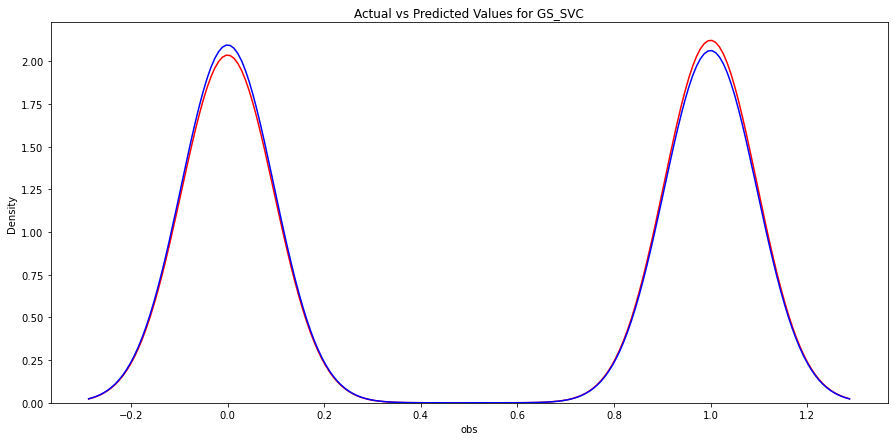

In [94]:
plt.figure(figsize=(15, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot( gsv_preds, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values for GS_SVC')


plt.show()
plt.close()

# Using RandomizedSearchCV Hyperparameter with Support Vector Machine


In [101]:
parameters1 = {'kernel': ['rbf', 'linear'],
              'C': [1,20,30],
              'gamma' : ['auto']
             }
svc1 = svm.SVC()
rsv_clf = RandomizedSearchCV(svc1, parameters1,
                             cv = 5,
                             return_train_score = False,
                             n_iter = 2)
rsv_clf.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=2,
                   param_distributions={'C': [1, 20, 30], 'gamma': ['auto'],
                                        'kernel': ['rbf', 'linear']})

In [102]:
rsv_preds = rsv_clf.predict(X_test)

rsv_score = rsv_clf.score(X_test, y_test)
rsv_score

0.6063995837669095

In [103]:
rsv_clf.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 20}

In [104]:
#print the accuracy of the randomized search cv with svm
accuracy_rsv = accuracy_score(y_test, rsv_preds)

print("Accuracy: %.2f%%" % (accuracy_rsv * 100.0))

print(classification_report(y_test, rsv_preds))

Accuracy: 60.64%
              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59      1882
         1.0       0.61      0.63      0.62      1962

    accuracy                           0.61      3844
   macro avg       0.61      0.61      0.61      3844
weighted avg       0.61      0.61      0.61      3844



C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


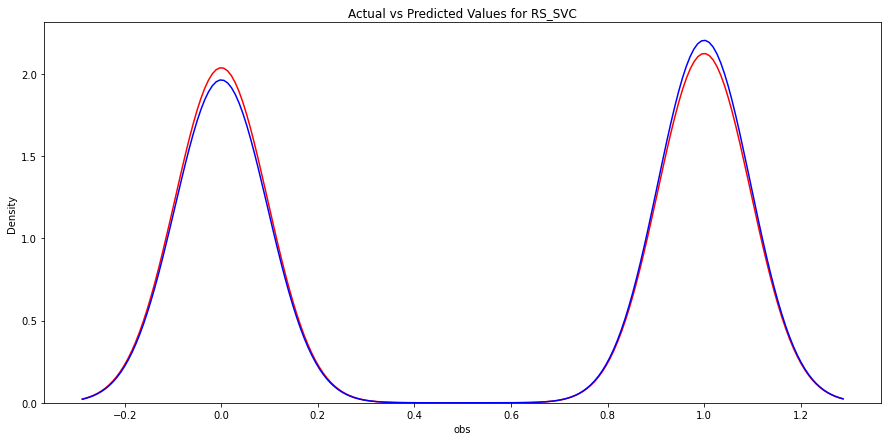

In [109]:
plt.figure(figsize=(15, 7))gb

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(rsv_preds, hist=False, color="b", label="Predicted Values" , ax=ax)

plt.title('Actual vs Predicted Values for RS_SVC')

plt.show()
plt.close()

# 4. Xgboost (Extreme gradient Booster)

In [106]:
# check xgboost version
import xgboost
from xgboost import XGBClassifier
print(xgboost.__version__)

1.5.1


In [107]:
# training the default XGB classifier 

#shuffle data
np.random.seed(42)

xg = XGBClassifier(use_label_encoder=False)

xg_fit = xg.fit(X_train, y_train)

xg_preds = xg.predict(X_test)

xg.score(X_test, y_test)

[16:33:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6391779396462018

In [108]:
#print the accuracy of the grid search cv with svm
accuracy_xg = accuracy_score(y_test, xg_preds)

print("Accuracy: %.2f%%" % (accuracy_xg * 100.0))

print(classification_report(y_test, xg_preds))

Accuracy: 63.92%
              precision    recall  f1-score   support

         0.0       0.64      0.61      0.62      1882
         1.0       0.64      0.67      0.65      1962

    accuracy                           0.64      3844
   macro avg       0.64      0.64      0.64      3844
weighted avg       0.64      0.64      0.64      3844



C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


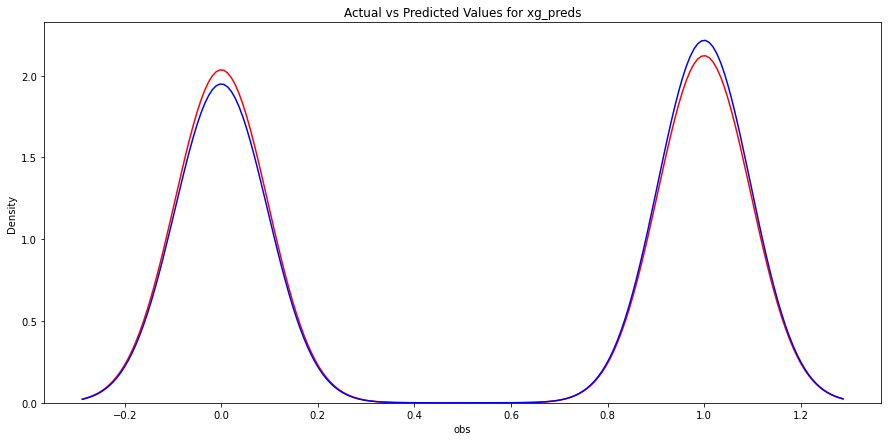

In [110]:
plt.figure(figsize=(15, 7))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(xg_preds, hist=False, color="b", label="Predicted Values" , ax=ax)

plt.title('Actual vs Predicted Values for xg_preds')

plt.show()
plt.close()

# GridSearchCV Hyperparameter with XGBoost

In [111]:
#
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xg_gs = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                                                param_grid = param_test1, scoring='roc_auc', n_jobs=4, cv=5)

xg_gs.fit(X_train,y_train)

C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [112]:
xg_gs_preds = xg_gs.predict(X_test)

In [113]:
 xg_gs.best_params_, xg_gs.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.6972585810726628)

In [114]:
xg_gs.score(X_test, y_test)

0.7113412001243608

In [115]:
#print the accuracy of the grid search cv with svm
accuracy_xg_gs = accuracy_score(y_test, xg_gs_preds)

print("Accuracy: %.2f%%" % (accuracy_xg_gs * 100.0))

print(classification_report(y_test, xg_gs_preds))

Accuracy: 65.45%
              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64      1882
         1.0       0.66      0.67      0.67      1962

    accuracy                           0.65      3844
   macro avg       0.65      0.65      0.65      3844
weighted avg       0.65      0.65      0.65      3844



C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Amakapc.LAPTOP-1UBS8G8S\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


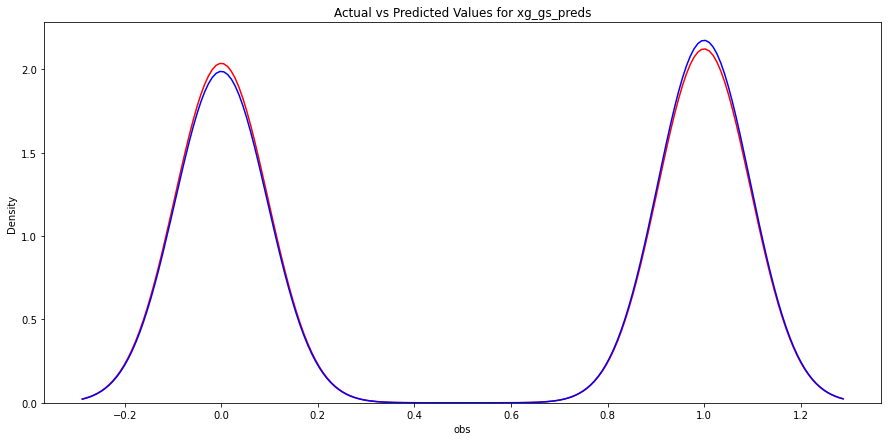

In [116]:
plt.figure(figsize=(15, 7))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(xg_gs_preds, hist=False, color="b", label="Predicted Values" , ax=ax)

plt.title('Actual vs Predicted Values for xg_gs_preds')

plt.show()
plt.close()

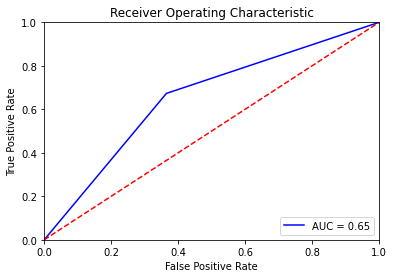

In [117]:
# calculate the fpr and tpr for all thresholds of the classification
probs_xg = xg_gs.predict_proba(X_test)
xg_pred = probs[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, xg_gs_preds)
roc_auc2 = metrics.auc(fpr2, tpr2)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()